# Quantify Anomalous Surveys

This notebook is used to identify extreme years based on mooring temperature and current velocity.


## Temperature Anomalies
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cmocean as cmo
from scipy.interpolate import griddata

%matplotlib inline

### 1.  Load in gridded mooring data

In [2]:
ds070 = xr.open_dataset('./data/ANMN/BMP070/gridded/IMOS_ANMN-NSW_TZ_20141118_BMP070_FV02_TEMP-gridded-timeseries_END-20210119_C-20210426.nc')
ds120 = xr.open_dataset('./data/ANMN/BMP120/gridded/IMOS_ANMN-NSW_TZ_20110329_BMP120_FV02_TEMP-gridded-timeseries_END-20210119_C-20210426.nc')

In [3]:
ds070

<xarray.Dataset>
Dimensions:     (TIME: 50243, DEPTH: 7)
Coordinates:
  * DEPTH       (DEPTH) float32 10.0 20.0 30.0 40.0 50.0 60.0 70.0
  * TIME        (TIME) datetime64[ns] 2014-11-18T21:00:00 ... 2021-01-19T21:0...
    LATITUDE    float64 ...
    LONGITUDE   float64 ...
Data variables:
    TEMP        (TIME, DEPTH) float32 ...
    TEMP_count  (TIME) int16 ...
Attributes: (12/41)
    Conventions:                 CF-1.6,IMOS-1.4
    abstract:                    Gridded Time Series Product: This file conta...
    acknowledgement:             Any users of IMOS data are required to clear...
    author:                      Klein, Eduardo
    author_email:                eduardo.kleinsalas@utas.edu.au
    citation:                    The citation in a list of references is: "IM...
    ...                          ...
    source_file_download:        https://s3-ap-southeast-2.amazonaws.com/imos...
    source_file_opendap:         http://thredds.aodn.org.au/thredds/dodsC/IMO...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    time_coverage_end:           2021-01-19T21:00:00Z
    time_coverage_start:         2014-11-18T21:00:00Z
    title:                       Gridded Time Series Product: TEMP interpolat...

### 2. Load in survey times

In [4]:
# Load survey times
survey_time = pd.read_csv("./data/surveys/meta/survey_times.csv")
survey_time['start_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['start_UTC']]
survey_time['end_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['end_UTC']]
survey_time

,id,year,start_UTC,end_UTC
0,2015_S1,2015,2015-09-30 20:35:42,2015-10-07 22:29:08
1,2016_S1,2016,2016-09-15 22:00:37,2016-09-28 03:22:35
2,2016_S2,2016,2016-10-22 03:09:45,2016-11-02 02:27:31
3,2017_S1,2017,2017-08-14 22:34:51,2017-08-26 04:17:06
4,2017_S2,2017,2017-10-02 22:24:52,2017-10-13 05:04:28
5,2018_S1,2018,2018-08-22 22:38:58,2018-09-04 04:42:08
6,2018_S2,2018,2018-09-27 21:54:38,2018-10-01 02:33:09
7,2019_S1,2019,2019-09-24 01:26:33,2019-09-26 02:22:16
8,2019_S2,2019,2019-09-30 21:36:31,2019-10-02 05:57:46


### 3. Plot complete Anomaly series

Text(0.5, 1.0, 'BMP070 Temp anomaly')

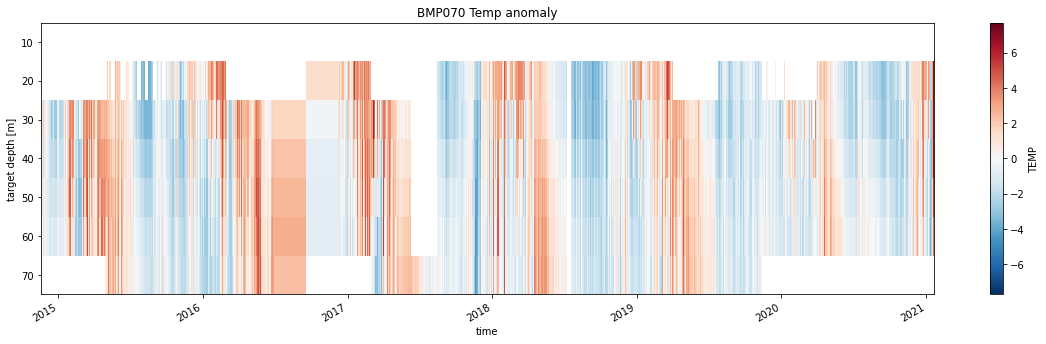

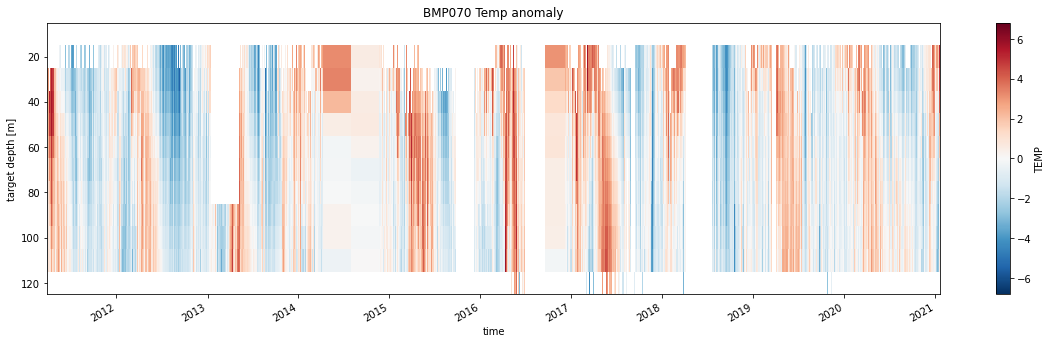

In [17]:
plt.figure(figsize=(20,5))
ds070_anom = (ds070.TEMP - ds070.TEMP.mean('TIME'))
ds070_anom.plot(x='TIME')
plt.gca().invert_yaxis()
plt.title('BMP070 Temp anomaly')

plt.figure(figsize=(20,5))
ds120_anom = (ds120.TEMP - ds120.TEMP.mean('TIME'))
ds120_anom.plot(x='TIME')
plt.gca().invert_yaxis()
plt.title('BMP070 Temp anomaly')

### 4. For each survey plot anomalies

<ipython-input-18-c76fcb699662>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,5))


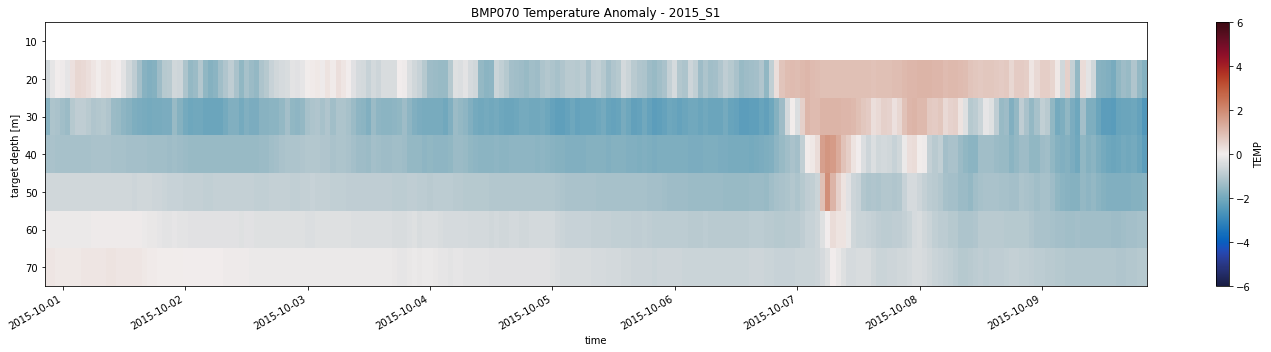

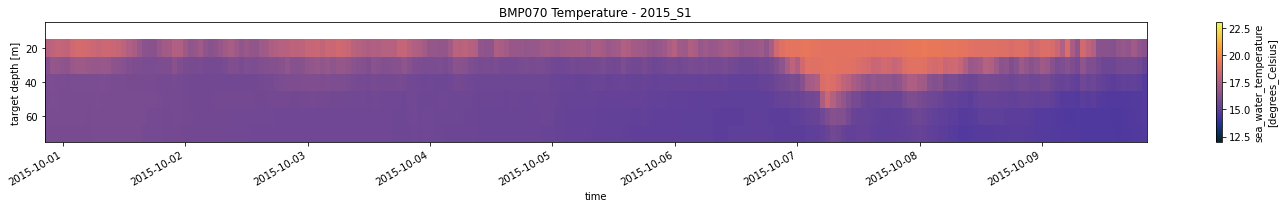

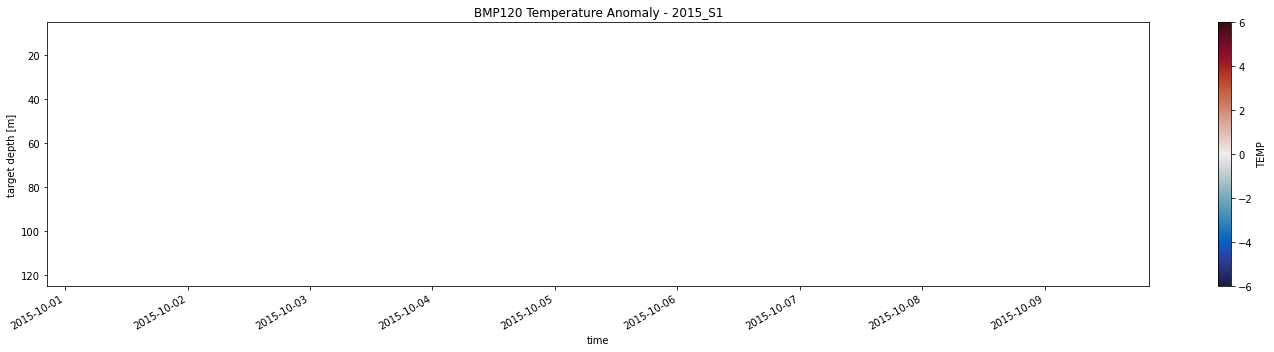

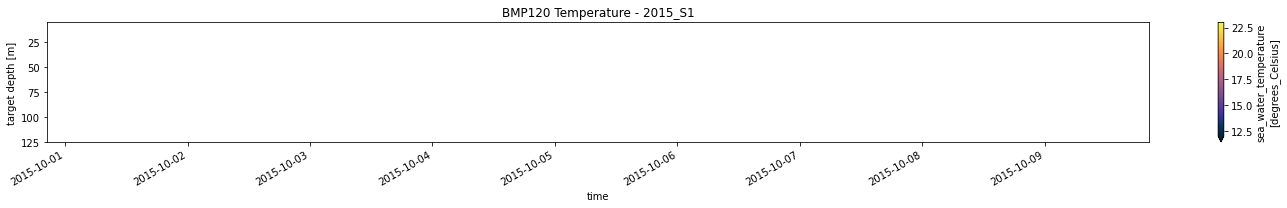

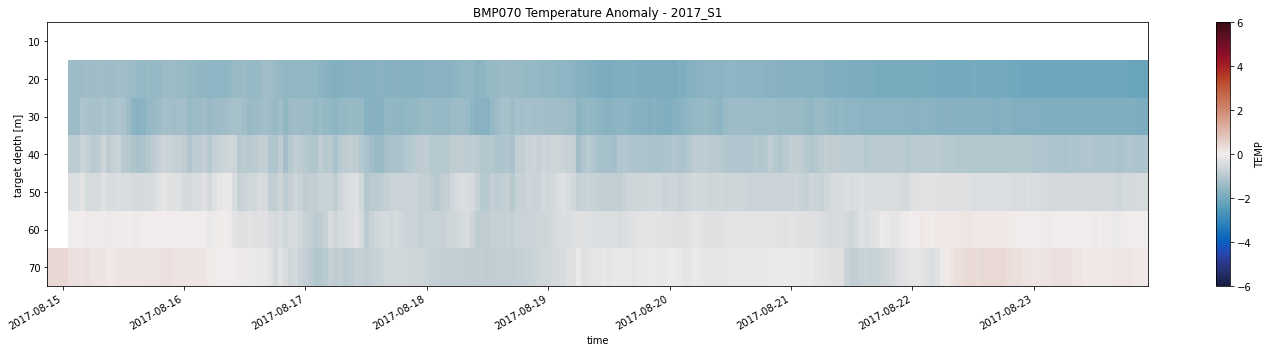

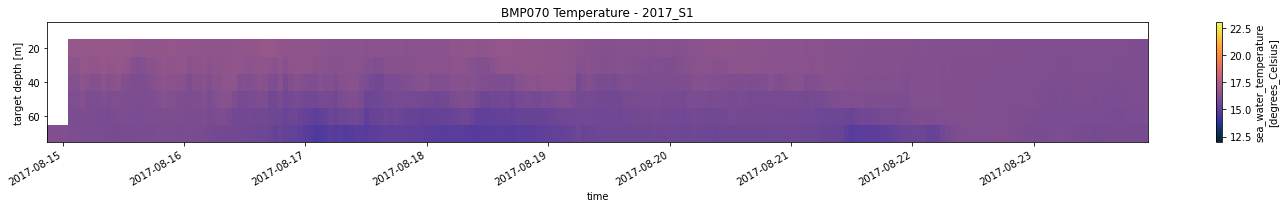

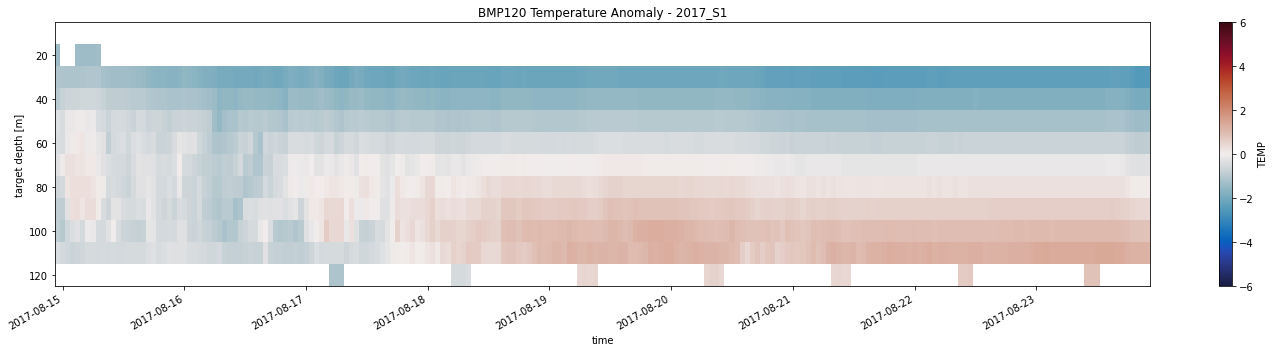

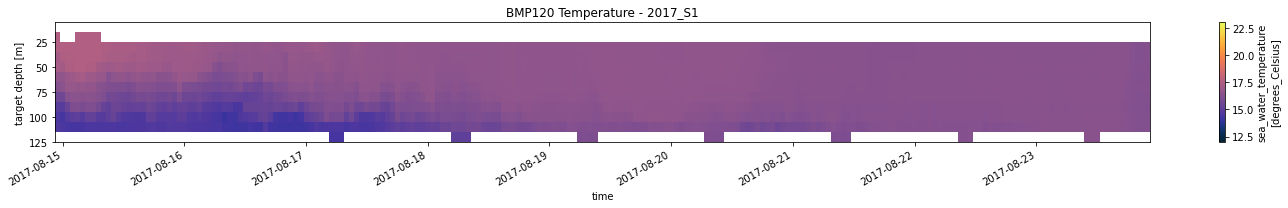

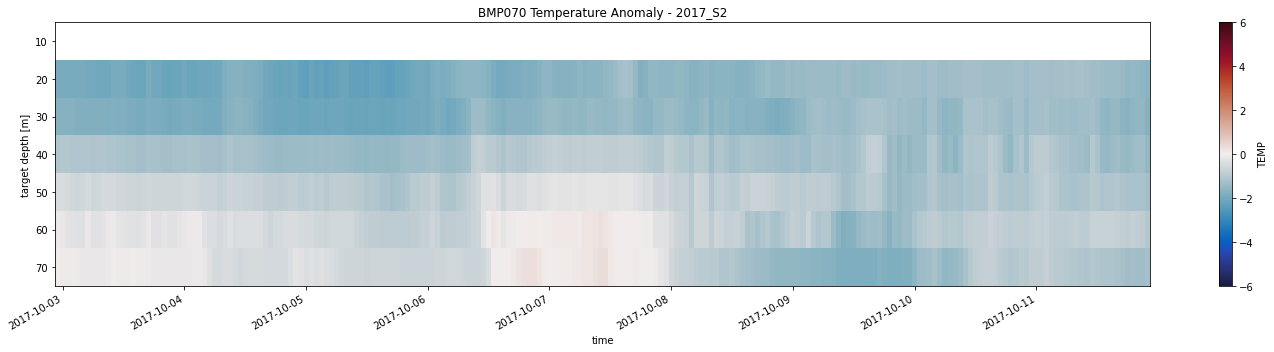

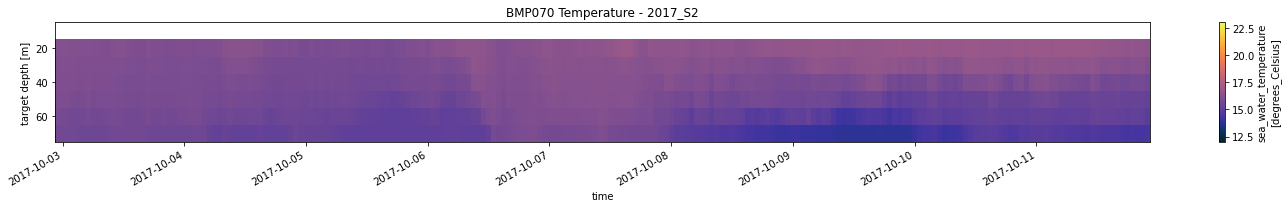

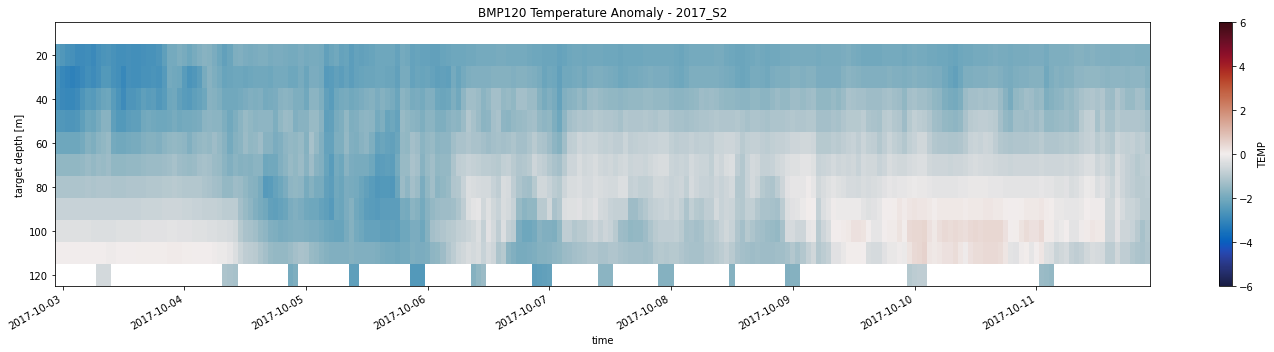

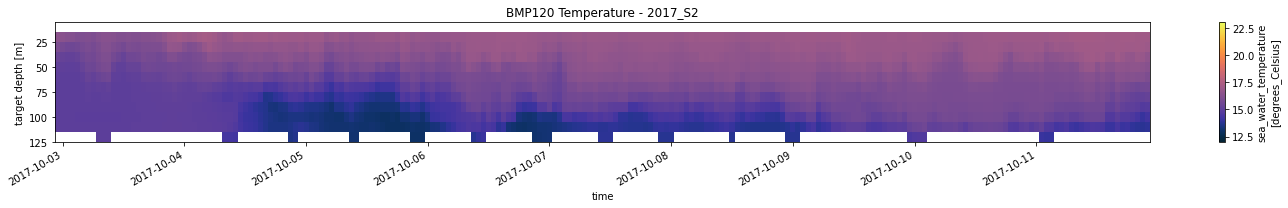

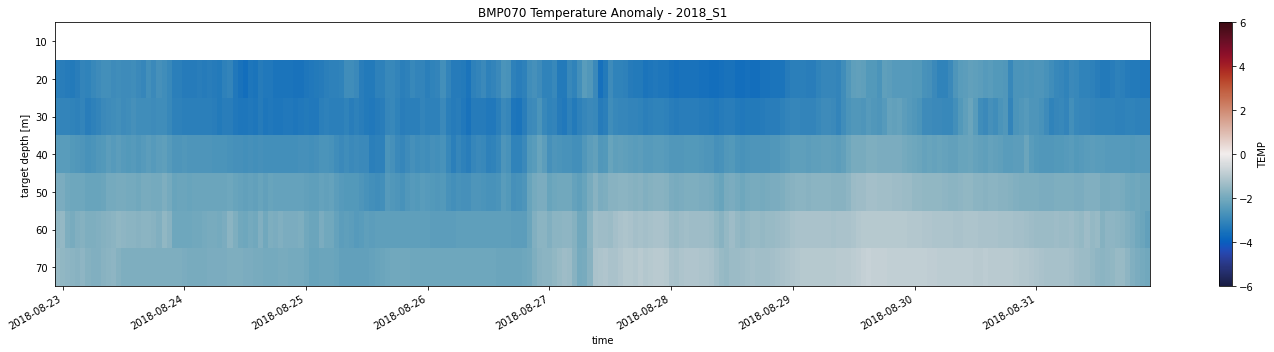

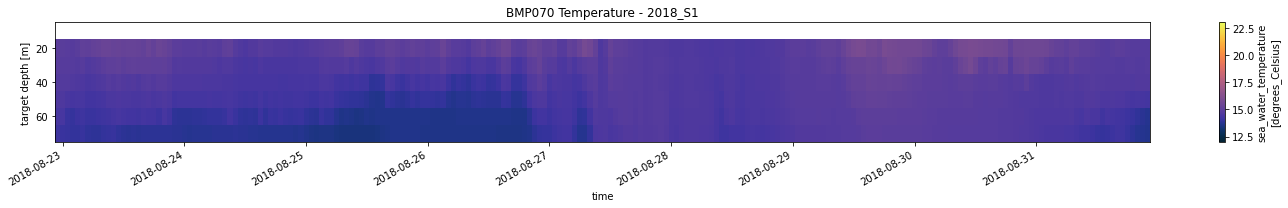

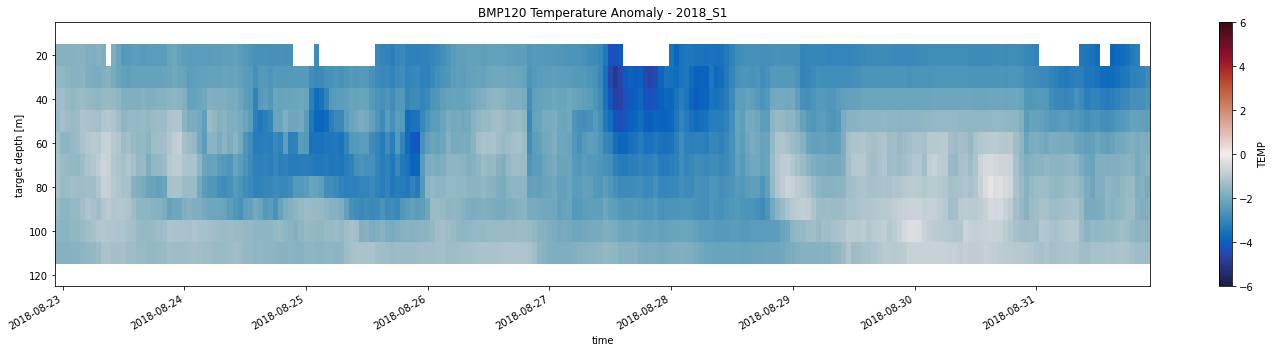

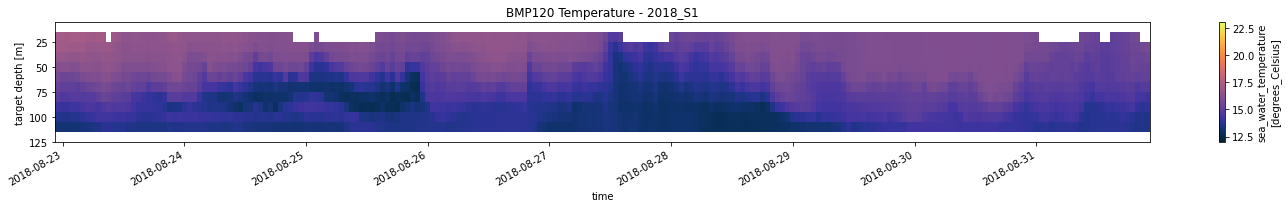

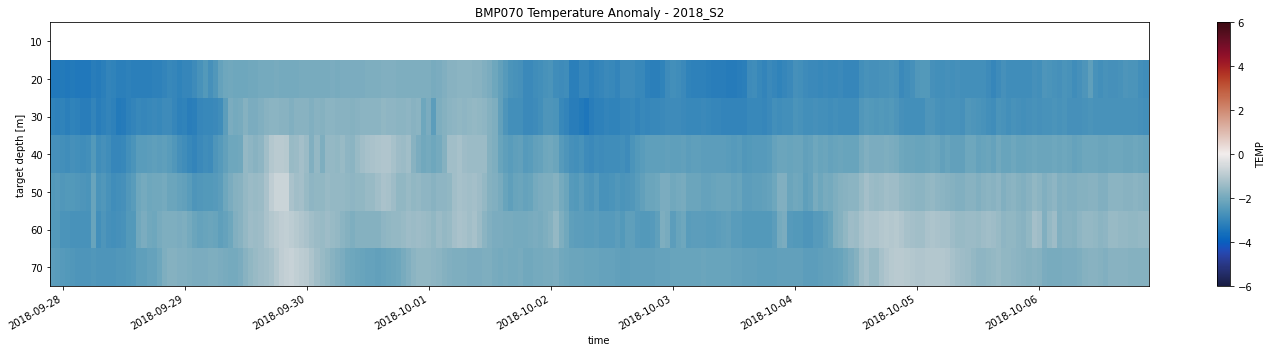

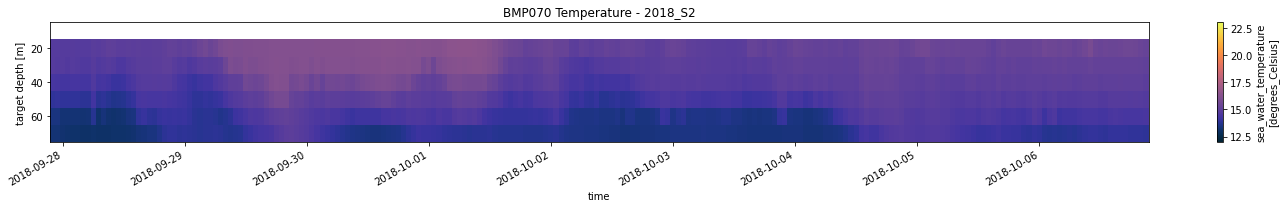

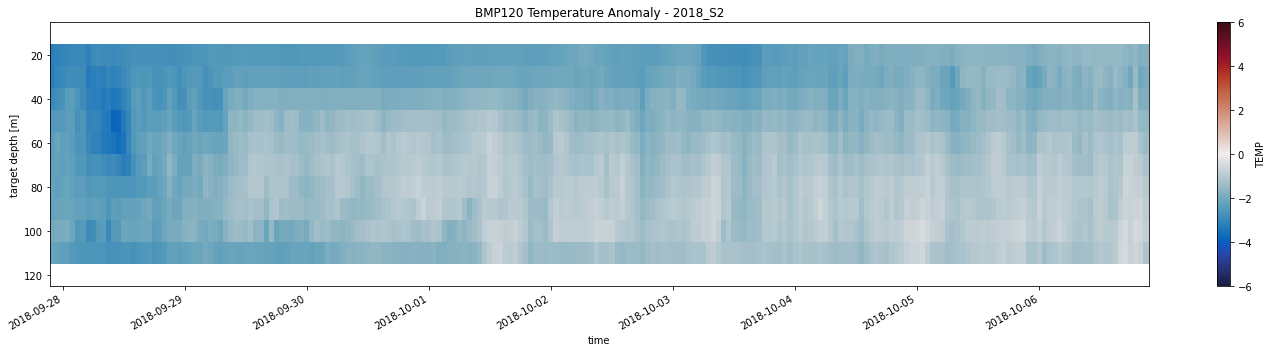

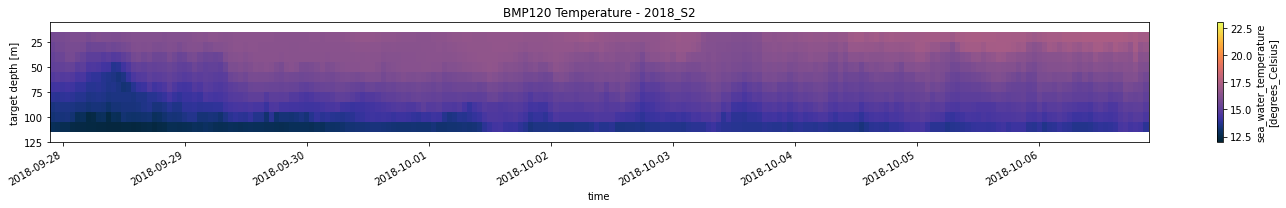

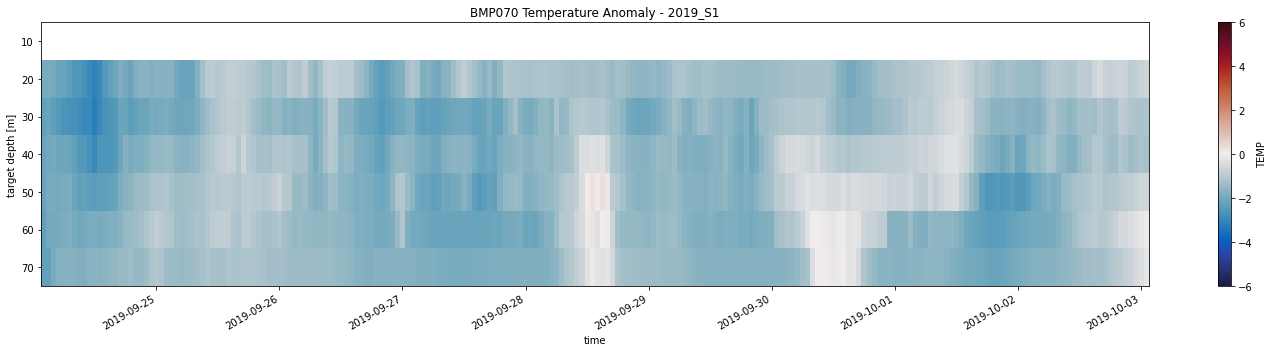

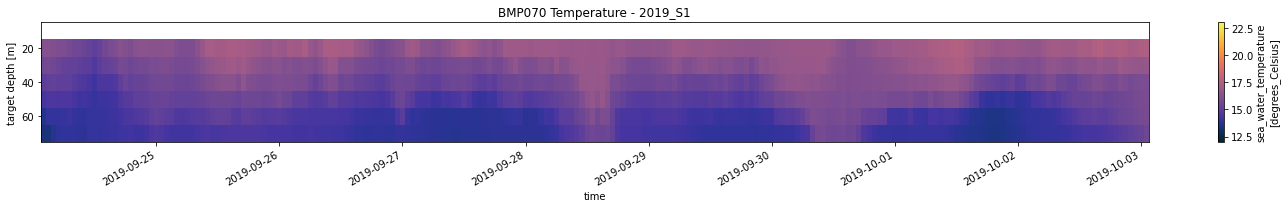

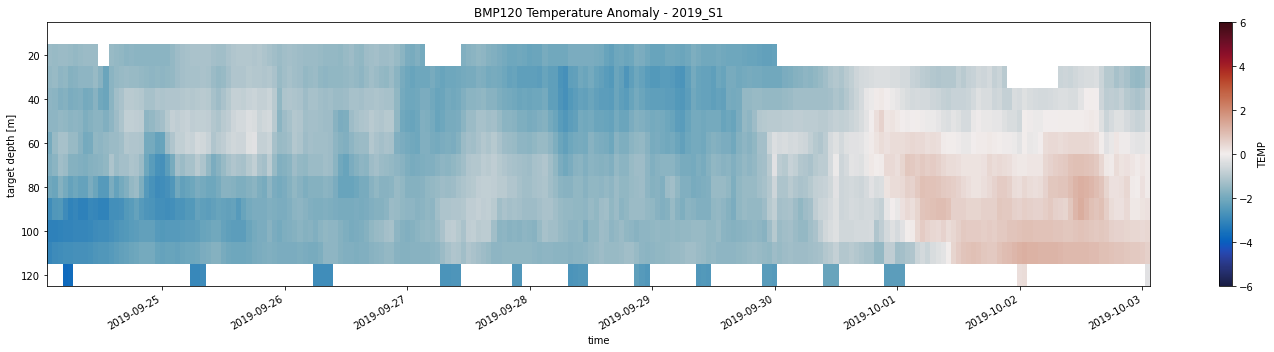

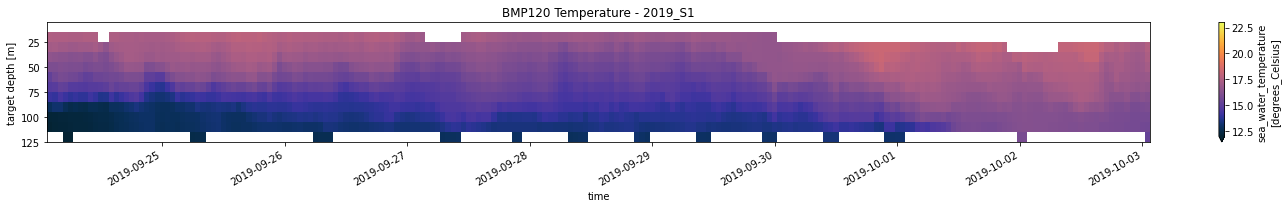

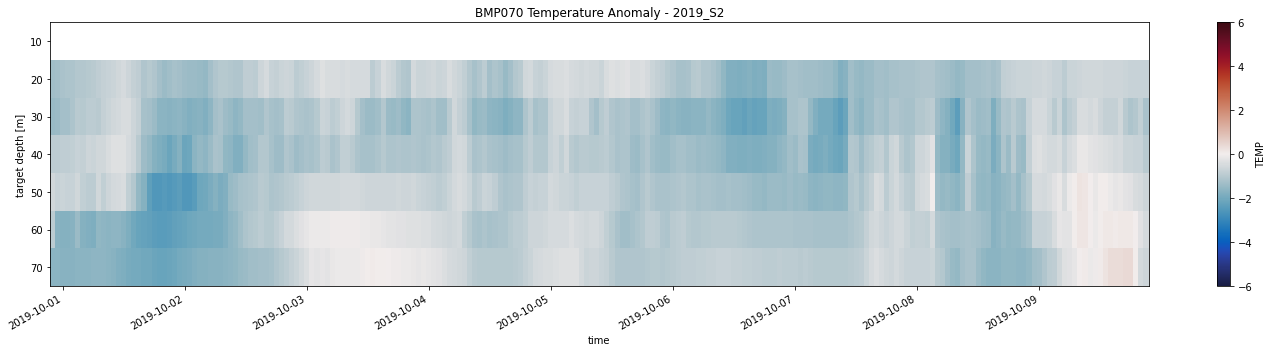

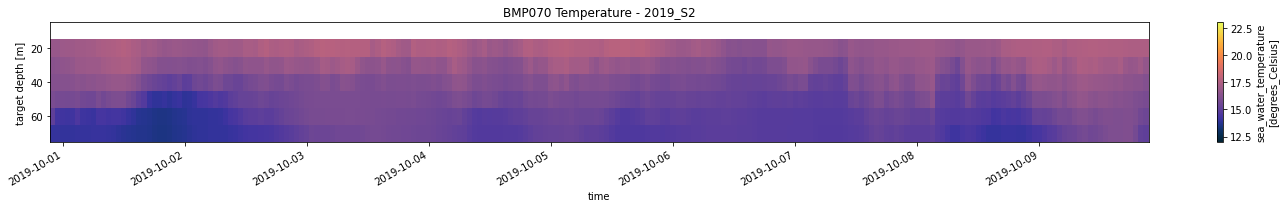

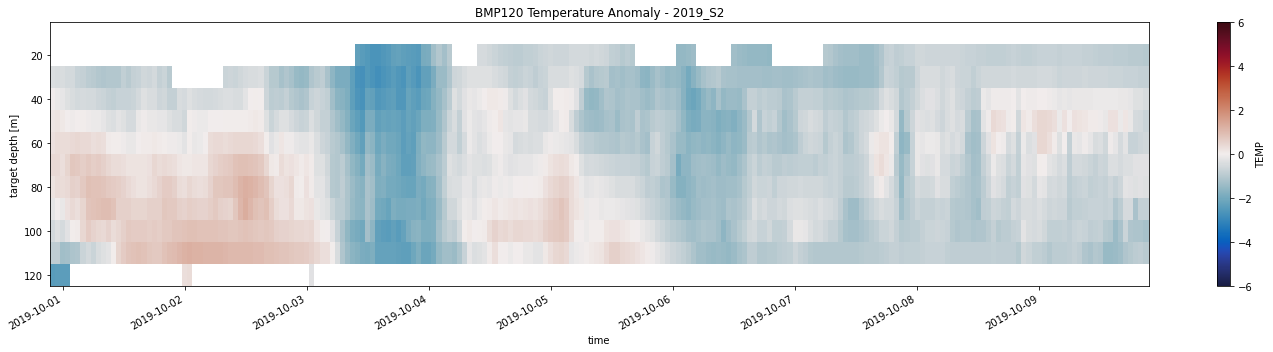

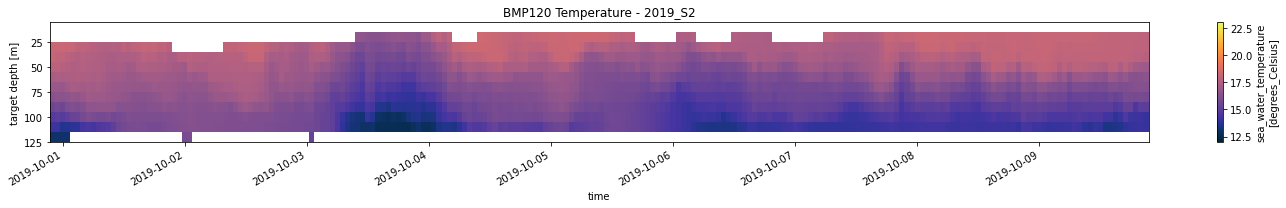

In [18]:
# Slice for each survey

for i, row in survey_time.iterrows():
    dat070_anom = ds070_anom.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    dat120_anom = ds120_anom.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    dat070_temp = ds070.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    dat120_temp = ds120.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    
    if len(dat070_anom.TIME) > 0:
        # plot BMP070 anomaly
        plt.figure(figsize=(20,5))
        dat070_anom.plot(x='TIME', cmap=cmo.cm.balance, vmin=-6, vmax=6)
        plt.gca().invert_yaxis()
        plt.title('BMP070 Temperature Anomaly - '+row.id)
        plt.tight_layout()
        plt.savefig('./output/mooring/TEMP/'+row.id+'_BMP070_temp_anomaly.png', facecolor='white')

        # plot BMP070 temp
        plt.figure(figsize=(20,3))
        dat070_temp.TEMP.plot(x='TIME', cmap=cmo.cm.thermal, vmin=12, vmax=23)
        plt.gca().invert_yaxis()
        plt.title('BMP070 Temperature - '+row.id)
        plt.tight_layout()
        plt.savefig('./output/mooring/TEMP/'+row.id+'_BMP070_temp.png', facecolor='white')
    
    if len(dat120_anom.TIME) > 0:
        # plot BMP120 anomaly
        plt.figure(figsize=(20,5))
        dat120_anom.plot(x='TIME', cmap=cmo.cm.balance, vmin=-6, vmax=6)
        plt.gca().invert_yaxis()
        plt.title('BMP120 Temperature Anomaly - '+row.id)
        plt.tight_layout()
        plt.savefig('./output/mooring/TEMP/'+row.id+'_BMP120_temp_anomaly.png', facecolor='white')

        # plot BMP120 temp
        plt.figure(figsize=(20,3))
        dat120_temp.TEMP.plot(x='TIME', cmap=cmo.cm.thermal, vmin=12, vmax=23)
        plt.gca().invert_yaxis()
        plt.title('BMP120 Temperature - '+row.id)
        plt.tight_layout()
        plt.savefig('./output/mooring/TEMP/'+row.id+'_BMP120_temp.png', facecolor='white')

## Velocity Anomalies
---

### 1. Load in aggregated mooring data

In this case we need to convert data to a Pandas data frame.

In [5]:
fname = './data/ANMN/BMP070/aggregated/IMOS_ANMN-NSW_VZ_20150430_BMP070_FV01_velocity-aggregated-timeseries_END-20210119_C-20210222.nc'
nc = xr.open_dataset(fname)
df070 = pd.DataFrame({'TIME': nc.TIME, 'VCUR': nc.VCUR, 'VCURqc': nc.VCUR_quality_control,'DEPTH' : nc.DEPTH, 'DEPTHqc' : nc.DEPTH_quality_control}).set_index('TIME')

fname = './data/ANMN/BMP120/aggregated/IMOS_ANMN-NSW_VZ_20141118_BMP120_FV01_velocity-aggregated-timeseries_END-20210119_C-20210222.nc'
nc = xr.open_dataset(fname)
df120 = pd.DataFrame({'TIME': nc.TIME, 'VCUR': nc.VCUR, 'VCURqc': nc.VCUR_quality_control,'DEPTH' : nc.DEPTH, 'DEPTHqc' : nc.DEPTH_quality_control}).set_index('TIME')

df120.head(5)

,VCUR,VCURqc,DEPTH,DEPTHqc
TIME,,,,
2014-11-18 23:20:00.000002304,0.082,1.0,112.58152,1.0
2014-11-18 23:20:00.000002304,0.090,1.0,108.58152,1.0
2014-11-18 23:20:00.000002304,0.069,1.0,104.58152,1.0
2014-11-18 23:20:00.000002304,0.089,1.0,100.58152,1.0
2014-11-18 23:20:00.000002304,0.091,1.0,96.58152,1.0


### 2. Apply quality control flags

In [6]:
df070 = df070[(df070.VCURqc == 1)&(df070.DEPTHqc == 1)]
df120 = df120[(df120.VCURqc == 1)&(df120.DEPTHqc == 1)]

### 3. Convert to Xarrays for easy time slicing

In [7]:
ds070 = df070.to_xarray()
ds120 = df120.to_xarray()

### 4. Slice and doownsample the xarrays and capture the data

In [8]:
# Lists to hold data
df070_catch = [None]*len(survey_time)
df120_catch = [None]*len(survey_time)

for i, row in survey_time.iterrows():
    dat070 = ds070.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    dat120 = ds120.sel(TIME=slice(row.start_UTC, row.start_UTC + timedelta(days=9)))
    
    if len(dat070.TIME) > 0:
        # Downsample so we don't crash the kernel
        dat070 = dat070.resample(TIME="1D").mean()
        # make dataframe
        df070_catch[i] = pd.DataFrame({'survey':row.id, 'VCUR': dat070.VCUR})
        
    if len(dat120.TIME) > 0:
        # Downsample so we don't crash the kernel
        dat120 = dat120.resample(TIME="1D").mean()
        # make dataframe
        df120_catch[i] = pd.DataFrame({'survey':row.id, 'VCUR': dat120.VCUR})

# Join data frames        
df070 = pd.concat(df070_catch)
df120 = pd.concat(df120_catch)
df070['BMP'] = 'BMP070'
df120['BMP'] = 'BMP120'
dfBoth = pd.concat([df070, df120])

### 5. Make the boxplots

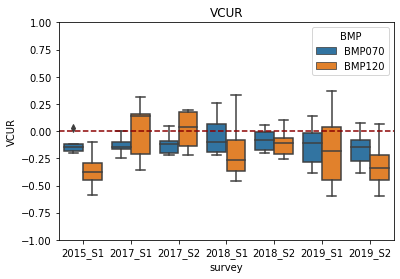

In [9]:
# BMP070
ax = sns.boxplot(x=dfBoth.survey, y=dfBoth.VCUR, hue=dfBoth.BMP)
ax.set_ylim([-1, 1]) 
ax.set_title('VCUR')
plt.axhline(y=0, ls='--', color='darkred')
plt.savefig('./output/mooring/VCUR/VCUR.png', facecolor='white')

In [24]:
# Save data output for plotting in R
dfBoth.to_csv("./data/ANMN/custom/VCUR_surveys.csv", index=False)